In [1]:
import keras
from keras.layers import Input, Dense, Flatten, LSTM
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features
from models.models import lstm_model, lstm_model_full
from evaluation import makeRoc, learningCurveLoss

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir ")
options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j_g,j_q,j1_pdgid,j_index,j1_etarot,j_z,j1_ptrel,j1_erel,j_t,j1_deltaR,j1_phirot,j_w
0,1,0,130.0,101333,0.000000,0,0.386118,0.382772,0,0.011056,0.000000,0
1,1,0,211.0,101333,-0.009859,0,0.107734,0.105703,0,0.023104,0.007236,0
2,1,0,321.0,101333,0.004508,0,0.094731,0.094339,0,0.006306,-0.002759,0
3,1,0,211.0,101333,0.028567,0,0.042086,0.042913,0,0.022473,-0.014909,0
4,1,0,-211.0,101333,-0.018020,0,0.039412,0.038547,0,0.025492,-0.003745,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0,0,111.0,300123134,-0.300495,1,0.000350,0.000344,0,0.380018,-0.315306,0
5131609,0,0,111.0,300123134,0.258936,1,0.000258,0.000256,0,0.294476,-0.349366,0
5131610,0,0,111.0,300123134,0.269149,1,0.000219,0.000215,0,0.255231,-0.270430,0
5131611,0,0,111.0,300123134,-0.213081,1,0.000116,0.000115,0,0.319973,-0.341398,0


In [5]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

# Self_Build Model

In [7]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = LSTM(16,return_sequences=True,  kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu',kernel_initializer='lecun_uniform',name='lstm_lstm',
         dropout=0.001, recurrent_dropout=0.00001)(Inputs)

x = Flatten()(x)
#x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Load model.py

In [ ]:
model = lstm_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )


# Load from json

In [ ]:
from keras.models import model_from_json
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.summary()

# Run training

In [8]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train_val, y_train_val, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 30s 16ms/step - loss: 1.1016 - accuracy: 0.6080 - val_loss: 1.0332 - val_accuracy: 0.6430
Epoch 2/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9618 - accuracy: 0.6716 - val_loss: 0.9521 - val_accuracy: 0.6778
Epoch 3/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9293 - accuracy: 0.6821 - val_loss: 0.9257 - val_accuracy: 0.6878
Epoch 4/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9135 - accuracy: 0.6884 - val_loss: 0.9299 - val_accuracy: 0.6851
Epoch 5/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9009 - accuracy: 0.6922 - val_loss: 0.9008 - val_accuracy: 0.6932
Epoch 6/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.8928 - accuracy: 0.6950 - val_loss: 0.8975 - val_accuracy: 0.6961
Epoch 7/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.8874 - accuracy: 0.6966 - val_loss: 0

1852/1852 [==============================] - 28s 15ms/step - loss: 0.8320 - accuracy: 0.7159 - val_loss: 0.8313 - val_accuracy: 0.7160
Epoch 57/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.8320 - accuracy: 0.7153 - val_loss: 0.8341 - val_accuracy: 0.7162
Epoch 58/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8336 - accuracy: 0.7139 - val_loss: 0.8481 - val_accuracy: 0.7137
Epoch 59/100
1852/1852 [==============================] - 31s 17ms/step - loss: 0.8322 - accuracy: 0.7143 - val_loss: 0.8489 - val_accuracy: 0.7105
Epoch 60/100
1852/1852 [==============================] - 31s 17ms/step - loss: 0.8309 - accuracy: 0.7149 - val_loss: 0.8437 - val_accuracy: 0.7147
Epoch 61/100
1852/1852 [==============================] - 30s 16ms/step - loss: 0.8297 - accuracy: 0.7149 - val_loss: 0.8375 - val_accuracy: 0.7148
Epoch 62/100
1852/1852 [==============================] - 30s 16ms/step - loss: 0.8286 - accuracy: 0.7171 - val_loss: 0.8535 

# Test

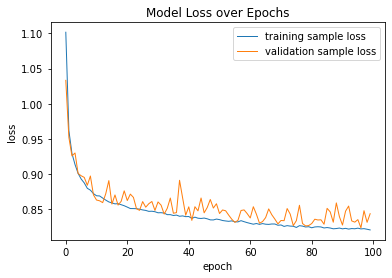

In [10]:
learningCurveLoss(history)

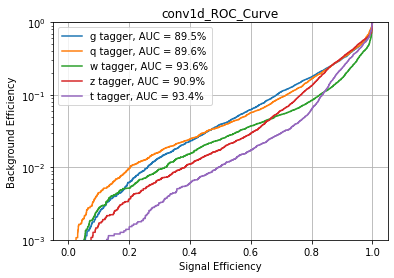

In [11]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')